In [1]:
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt

from utils_jax import BenchmarkGPR 
from utils_jax import relative_l2_loss
from utils_jax import PCA, matern_kernel_create, dot_kernel

import optuna
from utils_jax import cross_val_score

/opt/anaconda3/envs/jax-cpu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %% Visualize some predictions
def plot_truth_vs_prediction(truth, prediction, x):
    plt.figure(figsize=(12, 5))
    plt.plot(x, truth, label='Truth', color='blue')
    plt.plot(x, prediction, label='Prediction', color='red', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Truth vs Prediction')
    plt.legend()
    plt.grid()
    plt.show()

# Viscous Burgers equation


\begin{align}
&\frac{\partial u}{\partial t} = \Delta u - u \frac{\partial u}{\partial x} 
 \\
&u(0,x)  = u_0(x)
\end{align}

(periodic boundary conditions). 

We aim to learn the solution/flow operator:

$$
\mathcal{S}: u_0 \mapsto u(T,x)
$$

The initial condition is drawn from 

$$
u_0 \sim \mathcal N(0, (-\Delta + I)^{-s})
$$

## Load and plot the data

In [3]:
folder = "data/burgers/"

from scipy.io import loadmat
data = loadmat(folder + "burgers_data_R10.mat")
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'a', 'a_smooth', 'a_smooth_x', 'a_x', 'u'])


In [4]:
u0 = data['a']  # shape (N_samples, N_space)
uT  = data['u']  # shape (N_samples, N_space)

In [5]:
x = np.linspace(0, 1, u0.shape[1])
downsample_factor = 2**6 #
x = x[::downsample_factor]
u0 = u0[:, ::downsample_factor]
uT = uT[:, ::downsample_factor]

In [6]:
N = u0.shape[0]
n_train = int(0.8 * N)
u0_train = u0[:n_train,:]
uT_train = uT[:n_train,:]
u0_test = u0[n_train:,:]
uT_test = uT[n_train:,:]
print(u0_train.shape, uT_train.shape, u0_test.shape, uT_test.shape)

(1638, 128) (1638, 128) (410, 128) (410, 128)


## Input/output plot

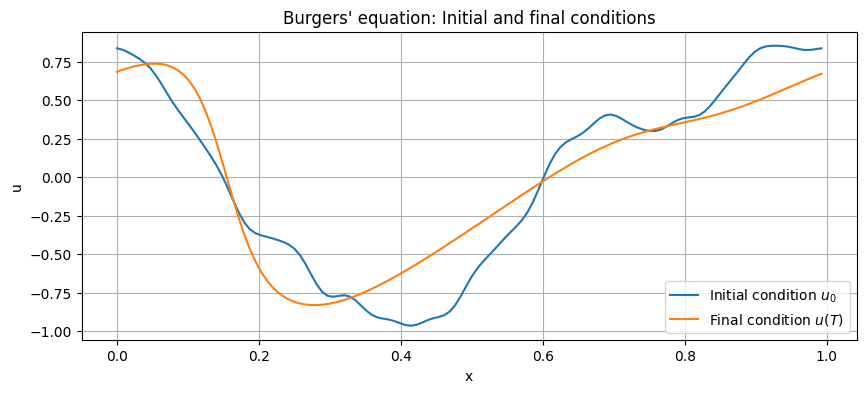

In [7]:
# Plot a an initial and final condition from the dataset
idx = 0
plt.figure(figsize=(10,4))
plt.plot(x, u0[idx], label='Initial condition $u_0$')
plt.plot(x, uT[idx], label='Final condition $u(T)$')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Burgers\' equation: Initial and final conditions')
plt.legend()
plt.grid()
plt.show()

# Encoder-Decoder

## Input

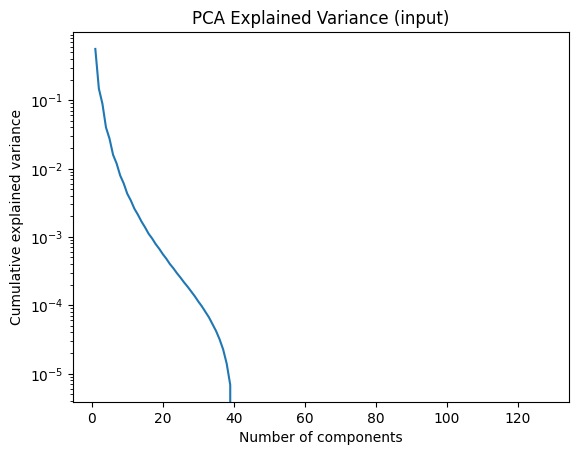

In [8]:
#%% first look at the pca on the input data
n_input = int(jnp.min(jnp.array(u0_train.shape)))
pca_input = PCA(n_components=n_input)
pca_input.fit(u0_train)
variance_input = pca_input.explained_variance_ratio_
plt.plot(jnp.arange(n_input) + 1, 1- jnp.cumsum(pca_input.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Explained Variance (input)')
plt.yscale("log")

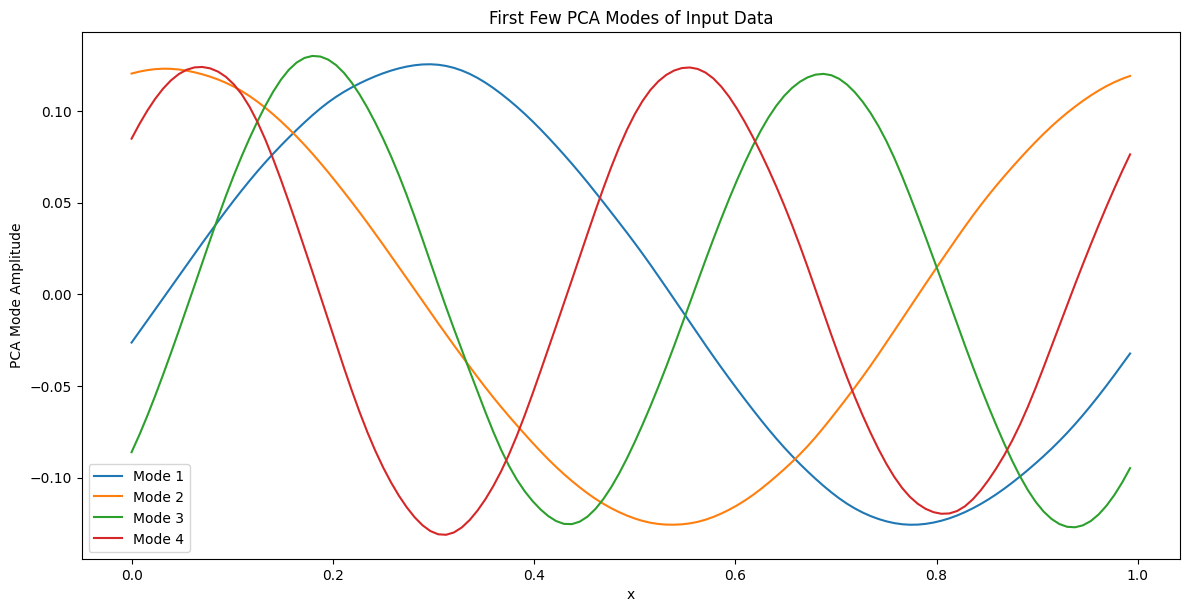

In [9]:
# Plot the first few PCA modes for the input
num_modes_to_plot = 4
components = pca_input.state[0]
plt.figure(figsize=(12, 6))
for i in range(num_modes_to_plot):
    mode = components[i]
    plt.plot(x, mode, label=f'Mode {i+1}')
    plt.xlabel('x')
    plt.ylabel('PCA Mode Amplitude')
plt.tight_layout()
plt.title('First Few PCA Modes of Input Data')
plt.legend()
plt.show()

## Output

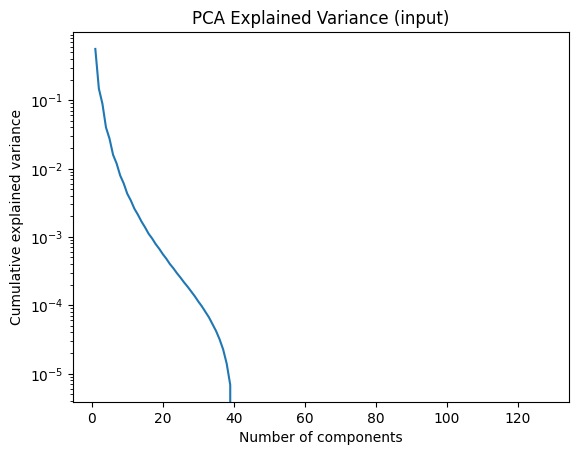

In [10]:
#%% first look at the pca on the input data
n_input = int(jnp.min(jnp.array(uT_train.shape)))
pca_output = PCA(n_components=n_input)
pca_output.fit(uT_train)
variance_input = pca_input.explained_variance_ratio_
plt.plot(jnp.arange(n_input) + 1, 1- jnp.cumsum(pca_input.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Explained Variance (input)')
plt.yscale("log")

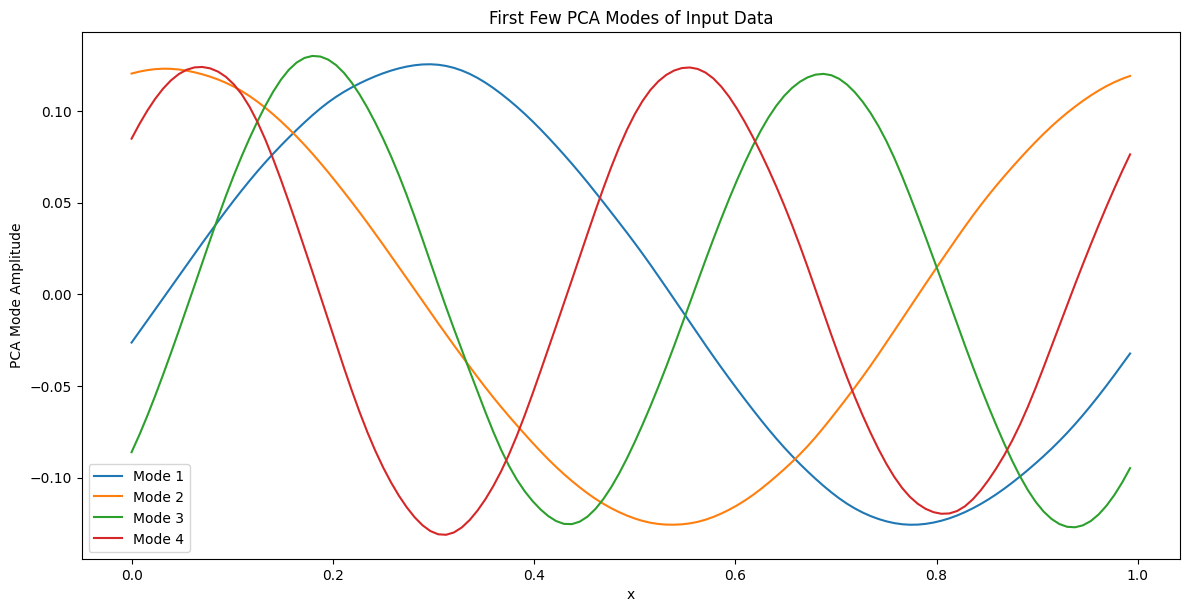

In [11]:
# Plot the first few PCA modes for the input
num_modes_to_plot = 4
components = pca_input.state[0]
plt.figure(figsize=(12, 6))
for i in range(num_modes_to_plot):
    mode = components[i]
    plt.plot(x, mode, label=f'Mode {i+1}')
    plt.xlabel('x')
    plt.ylabel('PCA Mode Amplitude')
plt.tight_layout()
plt.title('First Few PCA Modes of Input Data')
plt.legend()
plt.show()

# Build a operator 

In [12]:
# Define an operator

initial_guess = {
    "alpha": 1e-8,
    "length_scale": 1.0,
    "normalize": False,
    "pca_input_components": 20,
    "pca_output_components": 20,
    "weight_matern": 0.5,  
    "nu": "1.5"  # Default value for nu
}

matern_kernel = matern_kernel_create(nu=initial_guess["nu"])  # Default value for nu
def kernel(x,y, param):
    length_scale = param[0]
    weight_matern = param[1]
    weight_dot = 1.0 - weight_matern
    return weight_matern * matern_kernel(x, y, length_scale) + weight_dot * dot_kernel(x, y)


model = BenchmarkGPR(
    kernel=kernel,
    parameters=jnp.array([initial_guess['length_scale'], initial_guess['weight_matern']]),  # Initial guess for length_scale
    alpha= initial_guess['alpha'],
    pca_input_components=initial_guess['pca_input_components'], # does pca under the hood
    pca_output_components = initial_guess['pca_output_components'], # does pca under the hood
    normalize= initial_guess['normalize'],
    jit_kernel=True,
)

In [13]:
#%% Fir the model
model.fit(u0_train, uT_train)  # Fit the model with the training data and weights if provided

In [14]:
print("Initial cross validation loss ", jnp.mean(cross_val_score(model, u0_train, uT_train, cv=5, scoring=None)))  # Uses model.score

Initial cross validation loss  0.18711514328482584


In [15]:
pred_test = model.predict(u0_test)
test_error = relative_l2_loss(u0_test, pred_test)
print(f"Test Relative L2 Error: {test_error:.4e}")

Test Relative L2 Error: 3.9704e-01


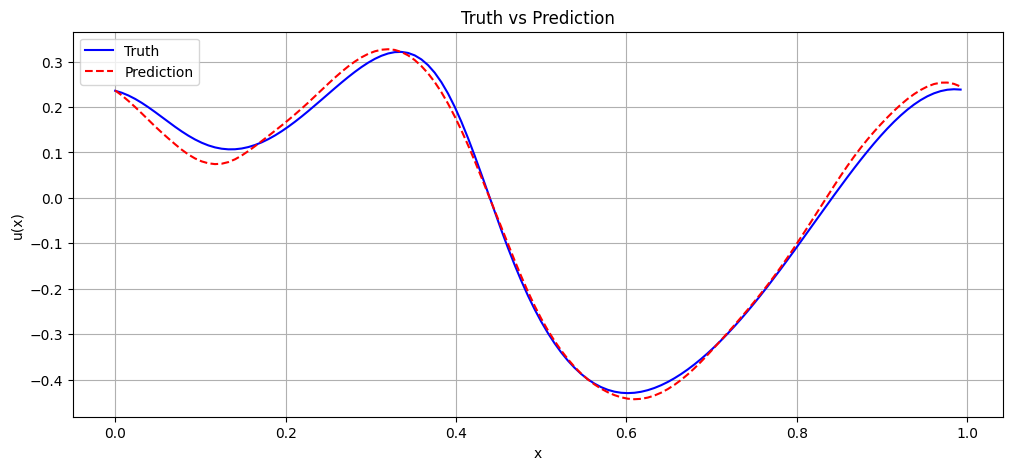

In [16]:
# Plot a prediction
idx = 0  # index of the test sample to plot
plot_truth_vs_prediction(uT_test[idx,:], pred_test[idx,:], x)

# Optimize hyper-parameters

In [17]:
max_pca_input = 128
max_pca_output = 128
def objective(trial):
    try:
        pca_input_components = trial.suggest_int('pca_input_components', 0, max_pca_input)
        alpha = trial.suggest_float('alpha', 1e-11, 1e0, log=True)
        length_scale = trial.suggest_float('length_scale', 1e-5, 1e5, log=True)
        normalize = trial.suggest_categorical('normalize', [True, False])
        pca_output_components = trial.suggest_int('pca_output_components', 0, max_pca_output)
        weight_matern = trial.suggest_float('weight_matern', 0.0, 1.0)
        nu = trial.suggest_categorical('nu', ['0.5', '1.5', '2.5', 'inf'])

        parameters = jnp.array([length_scale, weight_matern])
        matern_kernel = matern_kernel_create(nu=nu)  # Create the Matern kernel with the suggested nu

        def kernel(x,y, param):
            length_scale = param[0]
            weight_matern = param[1]
            weight_dot = 1.0 - weight_matern
            return weight_matern * matern_kernel(x, y, length_scale) + weight_dot * dot_kernel(x, y)


        model = BenchmarkGPR(
            kernel=kernel,
            parameters=parameters,
            alpha=alpha,
            normalize=normalize,
            pca_input_components=pca_input_components,
            pca_output_components=pca_output_components,
        )

        score = cross_val_score(model, u0_train, uT_train, cv=5, scoring = None)  # Uses model.score
        score = jnp.mean(score)
        if jnp.isnan(score) or jnp.isinf(score):
            return jnp.inf
        return score

    except Exception as e:
        print(f"Trial failed with error: {e}")
        return jnp.inf


In [18]:
initial_guess = {
    "alpha": 1e-8,
    "length_scale": 1.0,
    "normalize": False,
    "pca_input_components": 20,
    "pca_output_components": 20,
    "weight_matern": 0.5,  
    "nu": "1.5",  # Default value for nu
}

n_trials = 100
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=42),
    direction="minimize",
    load_if_exists=False,   # lets you resume from the same DB
)
# Add initial guess as first trial
study.enqueue_trial(initial_guess)
study.optimize(objective, n_trials=n_trials)  # Optimize hyper-parameters

[I 2026-01-06 16:28:39,801] A new study created in memory with name: no-name-0d530ba5-b28a-4c7e-9862-fe32468d7149
[I 2026-01-06 16:28:40,050] Trial 0 finished with value: 0.18711514328482584 and parameters: {'pca_input_components': 20, 'alpha': 1e-08, 'length_scale': 1.0, 'normalize': False, 'pca_output_components': 20, 'weight_matern': 0.5, 'nu': '1.5'}. Best is trial 0 with value: 0.18711514328482584.
[I 2026-01-06 16:28:40,940] Trial 1 finished with value: 0.3011531823365703 and parameters: {'pca_input_components': 48, 'alpha': 0.28698379250004885, 'length_scale': 208.9004704926666, 'normalize': True, 'pca_output_components': 20, 'weight_matern': 0.05808361216819946, 'nu': '0.5'}. Best is trial 0 with value: 0.18711514328482584.
[I 2026-01-06 16:28:41,765] Trial 2 finished with value: 0.3679679854816043 and parameters: {'pca_input_components': 125, 'alpha': 0.014350566608281143, 'length_scale': 0.001328590390054419, 'normalize': False, 'pca_output_components': 39, 'weight_matern': 0

In [19]:
print("Best trial:")
print("  Value: {}".format(study.best_trial.value))
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))


Best trial:
  Value: 0.023633798036361217
  Params: 
    pca_input_components: 29
    alpha: 2.5294445608858963e-08
    length_scale: 9.618495690001364
    normalize: False
    pca_output_components: 112
    weight_matern: 0.8948883663182707
    nu: 2.5


In [20]:
#%% Fit the model with the best parameters
best_params = study.best_trial.params
nu = best_params['nu']
matern_kernel = matern_kernel_create(nu=nu)  # Create the Matern kernel with the best nu
def kernel(x,y, param):
    length_scale = param[0]
    weight_matern = param[1]
    weight_dot = 1.0 - weight_matern
    return weight_matern * matern_kernel(x, y, length_scale) + weight_dot * dot_kernel(x, y)

parameters = jnp.array([best_params['length_scale'], best_params['weight_matern']])
best_params["parameters"] = list([best_params['length_scale'], best_params['weight_matern']])
model = BenchmarkGPR(
    kernel = kernel,
    alpha=best_params['alpha'],
    parameters=parameters,
    normalize=best_params['normalize'],
    pca_input_components=best_params['pca_input_components'],
    pca_output_components=best_params['pca_output_components'],
)

model.fit(u0_train, uT_train)  # Fit the model with the training data and weights if provided

In [21]:
print("Final cross validation loss ", jnp.mean(cross_val_score(model, u0_train, uT_train, cv=5, scoring=None)))  # Uses model.score

Final cross validation loss  0.023633798036361217


In [22]:
pred_test = model.predict(u0_test)
test_error = relative_l2_loss(uT_test, pred_test)
print(f"Test Relative L2 Error: {test_error:.4e}")

Test Relative L2 Error: 2.2459e-02


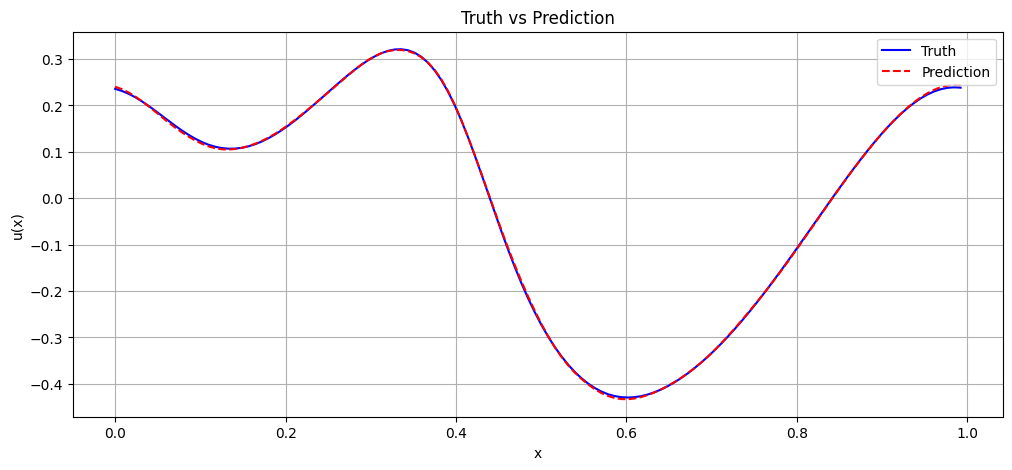

In [23]:
# Plot a prediction
idx = 0  # index of the test sample to plot
plot_truth_vs_prediction(uT_test[idx,:], pred_test[idx,:], x)